# HW4 – Conformal Prediction for Image Classification (Naive, APS, RAPS)

This notebook implements conformal prediction methods for image classification following **Angelopoulos et al., ICLR 2021**. It uses a pretrained **ResNet-152** (configurable) on ImageNet-1k and evaluates on the ImageNet validation set (if available) and the ImageNetV2 matched-frequency split. We compare three prediction-set methods:

- **Naive cumulative probability thresholding** (no conformal calibration)
- **APS (Adaptive Prediction Sets)**
- **RAPS (Regularized Adaptive Prediction Sets)**

Experiments mirror the paper:
1. Coverage vs set size on ImageNet-Val
2. Coverage vs set size on ImageNetV2 (distribution shift)
3. Histograms of set sizes for varying $\lambda$
4. Adaptiveness of RAPS vs image difficulty


In [16]:
import os
import random
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

try:
    from huggingface_hub import hf_hub_download
    HF_AVAILABLE = True
except ImportError:
    HF_AVAILABLE = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


def set_seed(seed: int = 0):
    """Set random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(0)


Using device: cpu


In [17]:
# Recovery & Diagnostics Cell
# Run this cell after a kernel crash to check saved progress and free memory

import os
import glob
import gc

# Define RESULTS_DIR if not already defined
if 'RESULTS_DIR' not in globals():
    RESULTS_DIR = "./results"
    os.makedirs(RESULTS_DIR, exist_ok=True)

print("=" * 60)
print("RECOVERY & DIAGNOSTICS")
print("=" * 60)

# Check saved scores
print("\n📁 Saved Score Files:")
score_files = glob.glob(os.path.join(RESULTS_DIR, "scores_*.pt"))
checkpoint_files = glob.glob(os.path.join(RESULTS_DIR, "*_checkpoint.pt"))
if score_files:
    for f in sorted(score_files):
        size_mb = os.path.getsize(f) / (1024 * 1024)
        print(f"  ✓ {os.path.basename(f)} ({size_mb:.1f} MB)")
else:
    print("  No saved scores found")

# Check checkpoint files (incomplete computations)
if checkpoint_files:
    print("\n⏸️  Checkpoint Files (incomplete computations):")
    for f in sorted(checkpoint_files):
        size_mb = os.path.getsize(f) / (1024 * 1024)
        print(f"  ⚠ {os.path.basename(f)} ({size_mb:.1f} MB)")
    print("  → These will be used to resume computation")
else:
    print("\n✓ No checkpoint files (all computations complete)")

# Memory cleanup
print("\n🧹 Cleaning up memory...")
gc.collect()
try:
    import torch
    if hasattr(torch, 'cuda') and torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("  ✓ CUDA cache cleared")
except:
    pass  # torch not available or not imported yet
print("  ✓ Python garbage collection completed")

# Check available variables
print("\n💾 Variables in memory:")
try:
    if 'scores_imagenet' in globals():
        print("  ✓ scores_imagenet (ImageNet scores)")
except:
    pass
try:
    if 'scores_imagenetv2' in globals():
        print("  ✓ scores_imagenetv2 (ImageNetV2 scores)")
except:
    pass

print("\n" + "=" * 60)
print("RECOVERY INSTRUCTIONS:")
print("=" * 60)
print("1. If scores are saved, just re-run the experiment cell")
print("2. It will automatically load from cache")
print("3. If you see checkpoint files, computation will resume")
print("4. To reduce memory usage, reduce BATCH_SIZE or NUM_WORKERS in Cell 3")
print("=" * 60)


RECOVERY & DIAGNOSTICS

📁 Saved Score Files:
  ✓ scores_imagenet_cal20000_eval20000_seed0.pt (763.2 MB)
  ✓ scores_imagenetv2_cal5000_eval5000_seed1.pt (190.8 MB)

✓ No checkpoint files (all computations complete)

🧹 Cleaning up memory...
  ✓ Python garbage collection completed

💾 Variables in memory:
  ✓ scores_imagenet (ImageNet scores)

RECOVERY INSTRUCTIONS:
1. If scores are saved, just re-run the experiment cell
2. It will automatically load from cache
3. If you see checkpoint files, computation will resume
4. To reduce memory usage, reduce BATCH_SIZE or NUM_WORKERS in Cell 3


## Checkpointing & Progress Saving

**This notebook includes automatic checkpointing to prevent data loss if the kernel shuts down.**

### Features:
- **Automatic caching**: Computed scores are automatically saved to `./results/` directory
- **Incremental checkpoints**: Progress is saved every 10 batches during logit computation
- **Resume capability**: If interrupted, the computation will automatically resume from the last checkpoint

### Tips to prevent kernel shutdowns:
1. **Reduce batch size** if you're running out of memory (set `BATCH_SIZE` lower)
2. **Reduce number of workers** if you have memory issues (set `NUM_WORKERS = 0` or `1`)
3. **Process datasets separately**: Run ImageNet and ImageNetV2 experiments separately
4. **Monitor memory usage**: Close other applications to free up RAM
5. **Use smaller evaluation sets**: Reduce `IMAGENET_N_EVAL` or `IMAGENETV2_N_EVAL` for faster testing

### Manual checkpoint management:
- Cached scores are saved as `.pt` files in `./results/`
- To force recomputation, delete the cache files or set `use_cache=False`
- Checkpoint files (`.pt` files with `_checkpoint` in name) are automatically cleaned up after successful completion


In [18]:
IMAGENET_ROOT = r"C:\Users\ducta\Downloads"  # user: set this to parent directory containing devkit and val folder
IMAGENETV2_ROOT = r"\Users\ducta\Downloads\imagenetv2-matched-frequency"
RESULTS_DIR = "./results"
os.makedirs(RESULTS_DIR, exist_ok=True)

NUM_CLASSES = 1000
BATCH_SIZE = 32  # Reduced from 64 to prevent crashes. Increase to 64 if you have enough RAM
NUM_WORKERS = 0  # Set to 0 to disable multiprocessing (saves memory). Increase to 2-4 if you have enough RAM

ALPHAS = [0.05, 0.10]  # target miscoverage

IMAGENET_N_CAL = 20000
IMAGENET_N_EVAL = 20000
IMAGENETV2_N_CAL = 5000
IMAGENETV2_N_EVAL = 5000

DEFAULT_KREG = 5
DEFAULT_LAMBDA = 0.2
RAPS_LAMBDAS_FOR_EXP3 = [0.0, 0.001, 0.01, 0.1, 1.0]


In [19]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

imagenet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


def load_imagenet_val(root: str):
    """Load ImageNet validation set if available locally."""
    if not os.path.isdir(root):
        print("ImageNet root not found, skipping ImageNet experiments.")
        return None
    
    # Check if root points directly to val images folder, use parent if so
    val_folder_names = ["val", "ILSVRC2012_img_val"]
    if os.path.basename(root) in val_folder_names:
        parent_root = os.path.dirname(root)
        if os.path.isdir(parent_root):
            print(f"Detected val folder, using parent directory: {parent_root}")
            root = parent_root
    
    # Check for standard ImageNet structure
    devkit_file = os.path.join(root, "ILSVRC2012_devkit_t12.tar.gz")
    devkit_folder = os.path.join(root, "ILSVRC2012_devkit_t12")
    val_tar = os.path.join(root, "ILSVRC2012_img_val.tar")
    val_folder = os.path.join(root, "val")
    
    # Check if devkit exists (either as tar.gz or extracted folder)
    has_devkit = os.path.exists(devkit_file) or os.path.isdir(devkit_folder)
    
    # If we have extracted val folder but no devkit, try to find devkit in parent
    if os.path.isdir(val_folder) and not has_devkit:
        parent_dir = os.path.dirname(root)
        parent_devkit_file = os.path.join(parent_dir, "ILSVRC2012_devkit_t12.tar.gz")
        parent_devkit_folder = os.path.join(parent_dir, "ILSVRC2012_devkit_t12")
        if os.path.exists(parent_devkit_file) or os.path.isdir(parent_devkit_folder):
            root = parent_dir
            print(f"Found devkit in parent, using: {root}")
    
    try:
        ds = datasets.ImageNet(root=root, split="val", transform=imagenet_transform)
        print("Loaded ImageNet-Val with", len(ds), "images.")
        return ds
    except RuntimeError as e:
        error_msg = str(e).lower()
        if "devkit" in error_msg or "archive" in error_msg or "tar" in error_msg:
            print(f"Cannot load ImageNet: {e}")
            print("\nTo fix this, ensure your IMAGENET_ROOT points to a directory containing:")
            print("  1. ILSVRC2012_devkit_t12.tar.gz (devkit archive)")
            print("  2. ILSVRC2012_img_val.tar (validation images archive) OR a 'val' folder")
            print(f"\nCurrent root: {root}")
            print("If your images are extracted, the root should be the parent directory.")
            return None
        else:
            raise


def ensure_imagenetv2_matched_frequency(root: str):
    """Ensure ImageNetV2 matched-frequency files are present, downloading if necessary."""
    os.makedirs(root, exist_ok=True)
    if any(os.scandir(root)):
        print("ImageNetV2 directory not empty; assuming data is present.")
        return root

    if not HF_AVAILABLE:
        raise RuntimeError("huggingface_hub not installed; install it or manually extract the tar.")

    print("Downloading ImageNetV2 matched-frequency from Hugging Face...")
    tar_path = hf_hub_download(
        repo_id="vaishaal/ImageNetV2",
        filename="imagenetv2-matched-frequency.tar.gz"
    )

    import tarfile
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall(path=root)

    print("Extracted ImageNetV2 under", root)
    return root


def load_imagenetv2(root: str):
    """Load ImageNetV2 matched-frequency split via ImageFolder."""
    ensure_imagenetv2_matched_frequency(root)
    entries = [e for e in os.scandir(root) if e.is_dir()]
    if len(entries) == 1:
        data_root = entries[0].path
    else:
        data_root = root

    ds = datasets.ImageFolder(root=data_root, transform=imagenet_transform)
    print("Loaded ImageNetV2 matched-frequency with", len(ds), "images.")
    return ds


In [20]:
imagenet_val = load_imagenet_val(IMAGENET_ROOT)
imagenetv2 = load_imagenetv2(IMAGENETV2_ROOT)


Loaded ImageNet-Val with 50000 images.
ImageNetV2 directory not empty; assuming data is present.
Loaded ImageNetV2 matched-frequency with 10000 images.


In [21]:
def split_for_calibration_and_eval(
    dataset,
    n_cal: int,
    n_eval: int,
    seed: int = 0
) -> Tuple[Subset, Subset]:
    indices = np.arange(len(dataset))
    rng = np.random.default_rng(seed)
    rng.shuffle(indices)

    n_total = min(len(indices), n_cal + n_eval)
    indices = indices[:n_total]

    cal_indices = indices[: min(n_cal, len(indices))]
    eval_indices = indices[min(n_cal, len(indices)): min(n_cal + n_eval, len(indices))]

    cal_set = Subset(dataset, cal_indices)
    eval_set = Subset(dataset, eval_indices)
    return cal_set, eval_set


def make_loader(dataset, batch_size: int = BATCH_SIZE, shuffle: bool = False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )


In [22]:
def load_pretrained_model(model_name: str = "resnet152") -> nn.Module:
    """Load a pretrained ImageNet classifier."""
    if model_name == "resnet152":
        model = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V2)
    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    else:
        raise ValueError(f"Unsupported model_name: {model_name}")
    model.eval()
    model.to(DEVICE)
    return model


class TemperatureScaler(nn.Module):
    """Simple temperature scaling for logits."""
    def __init__(self):
        super().__init__()
        self.log_temperature = nn.Parameter(torch.zeros(1))

    @property
    def temperature(self):
        return torch.exp(self.log_temperature)

    def forward(self, logits: torch.Tensor) -> torch.Tensor:
        return logits / self.temperature


def fit_temperature(model: nn.Module, loader: DataLoader, max_iters: int = 100) -> TemperatureScaler:
    """Fit temperature scaling using NLL loss on provided loader."""
    model.eval()
    scaler = TemperatureScaler().to(DEVICE)
    nll = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([scaler.log_temperature], lr=0.1)

    logits_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Collecting logits for temperature scaling"):
            images = images.to(DEVICE)
            logits = model(images)
            logits_list.append(logits.cpu())
            labels_list.append(labels)

    logits_all = torch.cat(logits_list, dim=0).to(DEVICE)
    labels_all = torch.cat(labels_list, dim=0).to(DEVICE)

    def eval_loss():
        optimizer.zero_grad()
        loss = nll(scaler(logits_all), labels_all)
        loss.backward()
        return loss

    for _ in range(max_iters):
        optimizer.step(eval_loss)

    print(f"Fitted temperature: {scaler.temperature.item():.4f}")
    scaler.eval()
    return scaler


def get_logits_and_labels(model: nn.Module, loader: DataLoader, temperature_scaler: TemperatureScaler = None, 
                          checkpoint_path: str = None, save_every_n_batches: int = 10):
    """Compute logits and labels for a dataset loader with checkpointing support."""
    model.eval()
    
    # Try to load checkpoint if it exists
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        logits_list = checkpoint.get('logits_list', [])
        labels_list = checkpoint.get('labels_list', [])
        start_batch = checkpoint.get('batch_idx', 0)
        print(f"Resuming from batch {start_batch}/{len(loader)}")
    else:
        logits_list = []
        labels_list = []
        start_batch = 0
    
    with torch.no_grad():
        # Process batches, skipping already processed ones
        pbar = tqdm(enumerate(loader), desc="Getting logits", total=len(loader), initial=start_batch)
        for batch_idx, (images, labels) in pbar:
            if batch_idx < start_batch:
                continue  # Skip already processed batches
                
            images = images.to(DEVICE)
            logits = model(images)
            if temperature_scaler is not None:
                logits = temperature_scaler(logits)
            logits_list.append(logits.cpu())
            labels_list.append(labels)
            
            # Save checkpoint periodically
            if checkpoint_path and (batch_idx + 1) % save_every_n_batches == 0:
                checkpoint = {
                    'logits_list': logits_list,
                    'labels_list': labels_list,
                    'batch_idx': batch_idx + 1
                }
                torch.save(checkpoint, checkpoint_path)
                print(f"  Checkpoint saved at batch {batch_idx + 1}")

    logits_all = torch.cat(logits_list, dim=0)
    labels_all = torch.cat(labels_list, dim=0)
    
    # Save final checkpoint
    if checkpoint_path:
        checkpoint = {
            'logits_list': logits_list,
            'labels_list': labels_list,
            'batch_idx': len(loader)
        }
        torch.save(checkpoint, checkpoint_path)
        print(f"Final checkpoint saved")
    
    return logits_all, labels_all


In [23]:
def softmax_logits_to_probs(logits: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.softmax(logits, dim=1)


def sorted_probs_and_indices(probs: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    sorted_probs, sorted_indices = torch.sort(probs, dim=1, descending=True)
    return sorted_probs, sorted_indices


def true_label_ranks(sorted_indices: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
    N, K = sorted_indices.shape
    labels_expanded = labels.view(N, 1).expand(-1, K)
    matches = (sorted_indices == labels_expanded)
    ranks = matches.float().argmax(dim=1)
    return ranks


def cumulative_probs(sorted_probs: torch.Tensor) -> torch.Tensor:
    return torch.cumsum(sorted_probs, dim=1)


In [24]:
def naive_set_sizes(sorted_probs: torch.Tensor, alphas: List[float]) -> Dict[float, torch.Tensor]:
    cumsums = cumulative_probs(sorted_probs)
    N, K = sorted_probs.shape
    sizes_by_alpha = {}

    for alpha in alphas:
        threshold = 1.0 - alpha
        mask = (cumsums >= threshold)
        first_true = mask.float().argmax(dim=1)
        no_true = ~mask.any(dim=1)
        first_true[no_true] = K - 1
        sizes_by_alpha[alpha] = first_true + 1
    return sizes_by_alpha


def naive_prediction_sets(sorted_indices: torch.Tensor, set_sizes: torch.Tensor) -> List[torch.Tensor]:
    N, K = sorted_indices.shape
    sets = []
    for i in range(N):
        L = int(set_sizes[i].item())
        sets.append(sorted_indices[i, :L])
    return sets


def raps_calibrate(sorted_probs: torch.Tensor,
                   sorted_indices: torch.Tensor,
                   labels: torch.Tensor,
                   alpha: float,
                   lambda_: float,
                   k_reg: int,
                   randomized: bool = True,
                   rng: np.random.Generator = None) -> float:
    if rng is None:
        rng = np.random.default_rng(0)

    N, K = sorted_probs.shape
    ranks = true_label_ranks(sorted_indices, labels)
    cumsums = cumulative_probs(sorted_probs)

    S_true = cumsums[torch.arange(N), ranks]
    ranks_1based = ranks + 1
    penalty = lambda_ * torch.clamp(ranks_1based - k_reg, min=0).float()

    E = S_true + penalty

    if randomized:
        U = torch.from_numpy(rng.uniform(size=N)).float()
        true_probs = sorted_probs[torch.arange(N), ranks]
        E = E - U * true_probs

    E_np = E.numpy()
    n = len(E_np)
    q_index = int(np.ceil((1.0 - alpha) * (n + 1))) - 1
    q_index = np.clip(q_index, 0, n - 1)
    tau_hat = float(np.partition(E_np, q_index)[q_index])
    return tau_hat


def raps_set_sizes(sorted_probs: torch.Tensor,
                   alpha: float,
                   lambda_: float,
                   k_reg: int,
                   tau_hat: float) -> torch.Tensor:
    N, K = sorted_probs.shape
    cumsums = cumulative_probs(sorted_probs)

    ranks_1based = torch.arange(1, K + 1)
    penalties = lambda_ * torch.clamp(ranks_1based - k_reg, min=0).float()
    penalties = penalties.view(1, K).expand(N, -1)

    E_all = cumsums + penalties

    mask = (E_all > tau_hat)
    all_false = ~mask.any(dim=1)
    first_exceed = mask.float().argmax(dim=1)
    first_exceed[all_false] = K

    sizes = first_exceed
    sizes[all_false] = K
    sizes = torch.clamp(sizes, min=1)
    return sizes


def aps_calibrate_and_sizes(sorted_probs_cal, sorted_indices_cal, labels_cal,
                            sorted_probs_eval, alpha, k_reg=0):
    tau_hat = raps_calibrate(
        sorted_probs_cal, sorted_indices_cal, labels_cal,
        alpha=alpha, lambda_=0.0, k_reg=k_reg
    )
    sizes = raps_set_sizes(
        sorted_probs_eval, alpha=alpha,
        lambda_=0.0, k_reg=k_reg, tau_hat=tau_hat
    )
    return tau_hat, sizes


def raps_calibrate_and_sizes(sorted_probs_cal, sorted_indices_cal, labels_cal,
                             sorted_probs_eval, alpha,
                             lambda_=DEFAULT_LAMBDA, k_reg=DEFAULT_KREG):
    tau_hat = raps_calibrate(
        sorted_probs_cal, sorted_indices_cal, labels_cal,
        alpha=alpha, lambda_=lambda_, k_reg=k_reg
    )
    sizes = raps_set_sizes(
        sorted_probs_eval, alpha=alpha,
        lambda_=lambda_, k_reg=k_reg, tau_hat=tau_hat
    )
    return tau_hat, sizes


In [25]:
def save_scores(scores: dict, filepath: str):
    """Save computed scores to disk."""
    os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
    torch.save(scores, filepath)
    print(f"Saved scores to {filepath}")


def load_scores(filepath: str) -> dict:
    """Load computed scores from disk."""
    if os.path.exists(filepath):
        scores = torch.load(filepath, map_location='cpu')
        print(f"Loaded scores from {filepath}")
        return scores
    return None


def load_scores_by_name(dataset_name: str, n_cal: int, n_eval: int, seed: int = 0) -> dict:
    """
    Helper function to load scores by dataset name and parameters.
    Useful for recovering from kernel crashes.
    
    Args:
        dataset_name: 'imagenet' or 'imagenetv2'
        n_cal: Number of calibration samples
        n_eval: Number of evaluation samples
        seed: Random seed used
    
    Returns:
        Dictionary of scores or None if not found
    """
    cache_file = os.path.join(RESULTS_DIR, f"scores_{dataset_name}_cal{n_cal}_eval{n_eval}_seed{seed}.pt")
    return load_scores(cache_file)


def compute_scores_for_dataset(model: nn.Module,
                               dataset,
                               n_cal: int,
                               n_eval: int,
                               seed: int = 0,
                               temperature_scaler: TemperatureScaler = None,
                               cache_file: str = None,
                               use_cache: bool = True):
    """
    Compute scores for a dataset with optional caching.
    
    Args:
        cache_file: Path to save/load cached scores. If None, uses RESULTS_DIR.
        use_cache: If True, load from cache if available and save results.
    """
    # Generate cache filename if not provided
    if cache_file is None:
        # Try to identify dataset type
        dataset_type = type(dataset).__name__
        dataset_root = str(getattr(dataset, 'root', ''))
        
        if 'ImageNet' in dataset_type or 'ilsvrc' in dataset_root.lower():
            dataset_name = 'imagenet'
        elif 'ImageFolder' in dataset_type and 'imagenetv2' in dataset_root.lower():
            dataset_name = 'imagenetv2'
        else:
            # Fallback: use a hash of the root path to create a safe filename
            import hashlib
            root_hash = hashlib.md5(dataset_root.encode()).hexdigest()[:8]
            dataset_name = f'dataset_{root_hash}'
        
        cache_file = os.path.join(RESULTS_DIR, f"scores_{dataset_name}_cal{n_cal}_eval{n_eval}_seed{seed}.pt")
    
    # Try to load from cache
    if use_cache:
        cached_scores = load_scores(cache_file)
        if cached_scores is not None:
            return cached_scores
    
    # Compute scores
    cal_set, eval_set = split_for_calibration_and_eval(dataset, n_cal, n_eval, seed=seed)
    cal_loader = make_loader(cal_set, shuffle=False)
    eval_loader = make_loader(eval_set, shuffle=False)

    # Use checkpointing for logits computation
    cal_checkpoint = cache_file.replace('.pt', '_cal_checkpoint.pt') if cache_file else None
    eval_checkpoint = cache_file.replace('.pt', '_eval_checkpoint.pt') if cache_file else None
    
    logits_cal, labels_cal = get_logits_and_labels(
        model, cal_loader, temperature_scaler, 
        checkpoint_path=cal_checkpoint, save_every_n_batches=10
    )
    logits_eval, labels_eval = get_logits_and_labels(
        model, eval_loader, temperature_scaler,
        checkpoint_path=eval_checkpoint, save_every_n_batches=10
    )

    probs_cal = torch.softmax(logits_cal, dim=1)
    probs_eval = torch.softmax(logits_eval, dim=1)

    s_cal, I_cal = sorted_probs_and_indices(probs_cal)
    s_eval, I_eval = sorted_probs_and_indices(probs_eval)

    scores = {
        "cal": {"logits": logits_cal, "labels": labels_cal, "probs": probs_cal, "sorted_probs": s_cal, "sorted_indices": I_cal},
        "eval": {"logits": logits_eval, "labels": labels_eval, "probs": probs_eval, "sorted_probs": s_eval, "sorted_indices": I_eval},
    }
    
    # Save to cache
    if use_cache:
        save_scores(scores, cache_file)
        # Clean up checkpoint files after successful completion
        if cal_checkpoint and os.path.exists(cal_checkpoint):
            os.remove(cal_checkpoint)
        if eval_checkpoint and os.path.exists(eval_checkpoint):
            os.remove(eval_checkpoint)
    
    # Memory cleanup - delete intermediate tensors to free memory
    del logits_cal, logits_eval, probs_cal, probs_eval
    import gc
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return scores


In [26]:
def coverage_from_set_sizes_and_labels(
    sorted_indices: torch.Tensor,
    set_sizes: torch.Tensor,
    labels: torch.Tensor
) -> float:
    N, K = sorted_indices.shape
    correct = 0
    for i in range(N):
        L = int(set_sizes[i].item())
        preds = sorted_indices[i, :L]
        if int(labels[i].item()) in preds.tolist():
            correct += 1
    return correct / float(N)


def average_set_size(set_sizes: torch.Tensor) -> float:
    return float(set_sizes.float().mean().item())


def topk_accuracies_from_probs(probs: torch.Tensor,
                               labels: torch.Tensor,
                               ks=(1, 5)) -> Dict[int, float]:
    _, topk_indices = probs.topk(max(ks), dim=1)
    results = {}
    for k in ks:
        correct = (topk_indices[:, :k] == labels.view(-1, 1)).any(dim=1).float().mean().item()
        results[k] = correct
    return results


## Experiment 1 – Coverage vs set size on ImageNet-Val

Run Naive, APS, and RAPS on ImageNet validation set (if available).

In [27]:
if imagenet_val is None:
    print("ImageNet not available; skipping Experiment 1.")
else:
    # Step 1: Compute scores (this may take a while, but is checkpointed)
    model = load_pretrained_model("resnet152")
    
    try:
        scores_imagenet = compute_scores_for_dataset(
            model,
            dataset=imagenet_val,
            n_cal=IMAGENET_N_CAL,
            n_eval=IMAGENET_N_EVAL,
            seed=0,
            temperature_scaler=None,
        )
        print("✓ Scores computed and saved successfully")
    finally:
        # Free model memory immediately after computation
        del model
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Step 2: Load scores and run analysis (separate to avoid memory issues)
    # If scores were just computed, they're already in memory
    # If kernel crashed during analysis, reload from cache
    try:
        # Check if scores exist in memory
        _ = scores_imagenet
    except NameError:
        print("Scores not in memory, loading from cache...")
        scores_imagenet = load_scores_by_name('imagenet', IMAGENET_N_CAL, IMAGENET_N_EVAL, seed=0)
        if scores_imagenet is None:
            raise RuntimeError("Scores not found in cache. Please run the computation step first.")
    
    s_cal = scores_imagenet["cal"]["sorted_probs"]
    I_cal = scores_imagenet["cal"]["sorted_indices"]
    labels_cal = scores_imagenet["cal"]["labels"]

    s_eval = scores_imagenet["eval"]["sorted_probs"]
    I_eval = scores_imagenet["eval"]["sorted_indices"]
    labels_eval = scores_imagenet["eval"]["labels"]

    topk = topk_accuracies_from_probs(scores_imagenet["eval"]["probs"], labels_eval)

    rows = []
    for alpha in ALPHAS:
        sizes_naive = naive_set_sizes(s_eval, [alpha])[alpha]
        cov_naive = coverage_from_set_sizes_and_labels(I_eval, sizes_naive, labels_eval)
        rows.append({"alpha": alpha, "method": "Naive", "coverage": cov_naive, "avg_set_size": average_set_size(sizes_naive)})

        tau_aps, sizes_aps = aps_calibrate_and_sizes(s_cal, I_cal, labels_cal, s_eval, alpha, k_reg=0)
        cov_aps = coverage_from_set_sizes_and_labels(I_eval, sizes_aps, labels_eval)
        rows.append({"alpha": alpha, "method": "APS", "coverage": cov_aps, "avg_set_size": average_set_size(sizes_aps)})

        tau_raps, sizes_raps = raps_calibrate_and_sizes(s_cal, I_cal, labels_cal, s_eval, alpha, lambda_=DEFAULT_LAMBDA, k_reg=DEFAULT_KREG)
        cov_raps = coverage_from_set_sizes_and_labels(I_eval, sizes_raps, labels_eval)
        rows.append({"alpha": alpha, "method": "RAPS", "coverage": cov_raps, "avg_set_size": average_set_size(sizes_raps)})

    df_exp1 = pd.DataFrame(rows)
    # Assign top-k accuracies (same value for all rows)
    df_exp1["top1"] = [topk[1]] * len(df_exp1)
    df_exp1["top5"] = [topk[5]] * len(df_exp1)
    display(df_exp1)


Loaded scores from ./results\scores_imagenet_cal20000_eval20000_seed0.pt
✓ Scores computed and saved successfully


AttributeError: module 'numpy' has no attribute 'matrix'

## Experiment 2 – Coverage vs set size on ImageNetV2

Repeat on the ImageNetV2 matched-frequency split to assess robustness under distribution shift.

In [ ]:
if imagenetv2 is None:
    print("ImageNetV2 not available; skipping Experiment 2.")
else:
    # Step 1: Compute scores (this may take a while, but is checkpointed)
    model = load_pretrained_model("resnet152")
    
    try:
        scores_imagenetv2 = compute_scores_for_dataset(
            model,
            dataset=imagenetv2,
            n_cal=IMAGENETV2_N_CAL,
            n_eval=IMAGENETV2_N_EVAL,
            seed=1,
            temperature_scaler=None,
        )
        print("✓ Scores computed and saved successfully")
    finally:
        # Free model memory immediately after computation
        del model
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    # Step 2: Load scores and run analysis (separate to avoid memory issues)
    # If scores were just computed, they're already in memory
    # If kernel crashed during analysis, reload from cache
    try:
        # Check if scores exist in memory
        _ = scores_imagenetv2
    except NameError:
        print("Scores not in memory, loading from cache...")
        scores_imagenetv2 = load_scores_by_name('imagenetv2', IMAGENETV2_N_CAL, IMAGENETV2_N_EVAL, seed=1)
        if scores_imagenetv2 is None:
            raise RuntimeError("Scores not found in cache. Please run the computation step first.")
    
    s_cal = scores_imagenetv2["cal"]["sorted_probs"]
    I_cal = scores_imagenetv2["cal"]["sorted_indices"]
    labels_cal = scores_imagenetv2["cal"]["labels"]

    s_eval = scores_imagenetv2["eval"]["sorted_probs"]
    I_eval = scores_imagenetv2["eval"]["sorted_indices"]
    labels_eval = scores_imagenetv2["eval"]["labels"]

    topk = topk_accuracies_from_probs(scores_imagenetv2["eval"]["probs"], labels_eval)

    rows = []
    for alpha in ALPHAS:
        sizes_naive = naive_set_sizes(s_eval, [alpha])[alpha]
        cov_naive = coverage_from_set_sizes_and_labels(I_eval, sizes_naive, labels_eval)
        rows.append({"alpha": alpha, "method": "Naive", "coverage": cov_naive, "avg_set_size": average_set_size(sizes_naive)})

        tau_aps, sizes_aps = aps_calibrate_and_sizes(s_cal, I_cal, labels_cal, s_eval, alpha, k_reg=0)
        cov_aps = coverage_from_set_sizes_and_labels(I_eval, sizes_aps, labels_eval)
        rows.append({"alpha": alpha, "method": "APS", "coverage": cov_aps, "avg_set_size": average_set_size(sizes_aps)})

        tau_raps, sizes_raps = raps_calibrate_and_sizes(s_cal, I_cal, labels_cal, s_eval, alpha, lambda_=DEFAULT_LAMBDA, k_reg=DEFAULT_KREG)
        cov_raps = coverage_from_set_sizes_and_labels(I_eval, sizes_raps, labels_eval)
        rows.append({"alpha": alpha, "method": "RAPS", "coverage": cov_raps, "avg_set_size": average_set_size(sizes_raps)})

    df_exp2 = pd.DataFrame(rows)
    # Assign top-k accuracies (same value for all rows)
    df_exp2["top1"] = [topk[1]] * len(df_exp2)
    df_exp2["top5"] = [topk[5]] * len(df_exp2)
    display(df_exp2)


Loaded scores from ./results\scores_imagenetv2_cal5000_eval5000_seed1.pt
✓ Scores computed and saved successfully


,alpha,method,coverage,avg_set_size,top1,top5
0,0.05,Naive,0.6098,623.763611,0.0096,0.0212
1,0.05,APS,0.9460,964.497986,0.0096,0.0212
2,0.05,RAPS,0.9506,966.548218,0.0096,0.0212
3,0.10,Naive,0.3884,364.788605,0.0096,0.0212
4,0.10,APS,0.8932,923.677795,0.0096,0.0212
5,0.10,RAPS,0.8914,922.528381,0.0096,0.0212


## Experiment 3 – Histograms of set sizes for different $\lambda$

Visualize how RAPS set sizes vary with the regularization parameter $\lambda$ for a fixed $lpha$ (default 0.1).

In [ ]:
alpha_hist = 0.1

def plot_histograms_for_dataset(s_cal, I_cal, labels_cal, s_eval, I_eval, labels_eval, dataset_name: str):
    import gc
    
    sizes_naive = naive_set_sizes(s_eval, [alpha_hist])[alpha_hist]
    plt.figure(figsize=(6, 4))
    plt.hist(sizes_naive.numpy(), bins=range(1, 50), alpha=0.7, label="Naive")
    plt.title(f"Experiment 3 – Naive set sizes (alpha={alpha_hist}, {dataset_name})")
    plt.xlabel("Set size")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    del sizes_naive
    gc.collect()

    tau_aps, sizes_aps = aps_calibrate_and_sizes(s_cal, I_cal, labels_cal, s_eval, alpha_hist, k_reg=0)
    plt.figure(figsize=(6, 4))
    plt.hist(sizes_aps.numpy(), bins=range(1, 50), alpha=0.7, label="APS")
    plt.title(f"Experiment 3 – APS set sizes (alpha={alpha_hist}, {dataset_name})")
    plt.xlabel("Set size")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
    del tau_aps, sizes_aps
    gc.collect()

    for lambda_ in RAPS_LAMBDAS_FOR_EXP3:
        print(f"Computing RAPS for lambda={lambda_}...")
        tau_raps, sizes_raps = raps_calibrate_and_sizes(
            s_cal, I_cal, labels_cal, s_eval, alpha_hist, lambda_=lambda_, k_reg=DEFAULT_KREG
        )
        plt.figure(figsize=(6, 4))
        plt.hist(sizes_raps.numpy(), bins=range(1, 50), alpha=0.7, label=f"RAPS lambda={lambda_}")
        plt.title(f"Experiment 3 – RAPS set sizes (alpha={alpha_hist}, lambda={lambda_}, {dataset_name})")
        plt.xlabel("Set size")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
        # Clean up after each plot
        del tau_raps, sizes_raps
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


if imagenet_val is not None:
    # Try to get scores from memory, otherwise load from cache
    try:
        scores = scores_imagenet
    except NameError:
        print("Loading ImageNet scores from cache...")
        scores = load_scores_by_name('imagenet', IMAGENET_N_CAL, IMAGENET_N_EVAL, seed=0)
        if scores is None:
            print("Scores not found. Computing scores (this may take a while)...")
            model = load_pretrained_model("resnet152")
            try:
                scores = compute_scores_for_dataset(model, imagenet_val, IMAGENET_N_CAL, IMAGENET_N_EVAL)
            finally:
                del model
                import gc
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
    
    plot_histograms_for_dataset(
        scores["cal"]["sorted_probs"], scores["cal"]["sorted_indices"], scores["cal"]["labels"],
        scores["eval"]["sorted_probs"], scores["eval"]["sorted_indices"], scores["eval"]["labels"],
        dataset_name="ImageNet-Val"
    )
elif imagenetv2 is not None:
    # Try to get scores from memory, otherwise load from cache
    try:
        scores = scores_imagenetv2
    except NameError:
        print("Loading ImageNetV2 scores from cache...")
        scores = load_scores_by_name('imagenetv2', IMAGENETV2_N_CAL, IMAGENETV2_N_EVAL, seed=1)
        if scores is None:
            print("Scores not found. Computing scores (this may take a while)...")
            model = load_pretrained_model("resnet152")
            try:
                scores = compute_scores_for_dataset(model, imagenetv2, IMAGENETV2_N_CAL, IMAGENETV2_N_EVAL)
            finally:
                del model
                import gc
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
    
    plot_histograms_for_dataset(
        scores["cal"]["sorted_probs"], scores["cal"]["sorted_indices"], scores["cal"]["labels"],
        scores["eval"]["sorted_probs"], scores["eval"]["sorted_indices"], scores["eval"]["labels"],
        dataset_name="ImageNetV2"
    )
else:
    print("No datasets available for Experiment 3.")


: 

## Experiment 4 – Adaptiveness of RAPS vs difficulty

Analyze how RAPS set sizes change across difficulty bins defined by true-class probabilities.

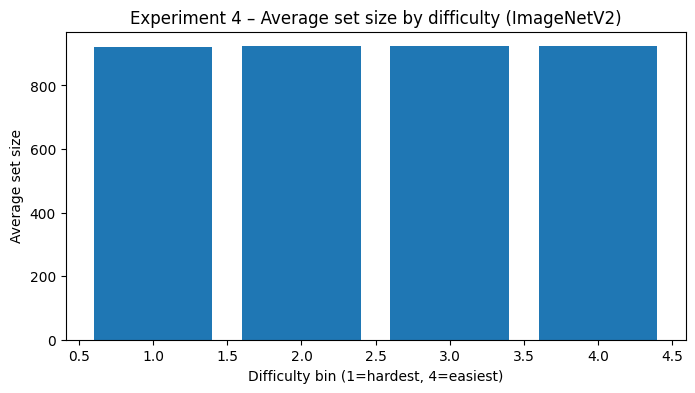

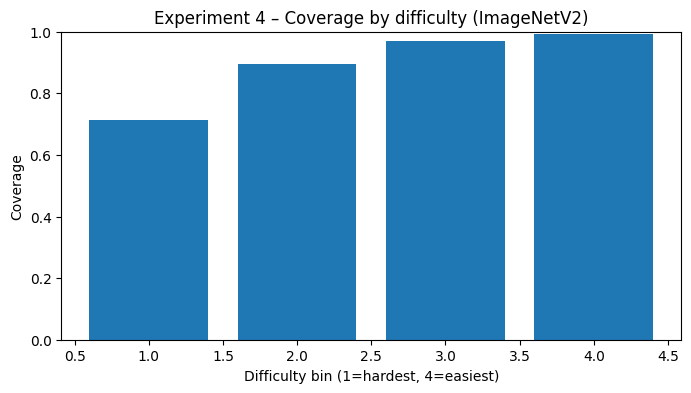

In [ ]:
alpha_adapt = 0.1
lambda_adapt = DEFAULT_LAMBDA


def analyze_adaptiveness(s_cal, I_cal, labels_cal, s_eval, I_eval, labels_eval, dataset_name: str):
    tau_raps, sizes_raps = raps_calibrate_and_sizes(
        s_cal, I_cal, labels_cal, s_eval, alpha_adapt, lambda_=lambda_adapt, k_reg=DEFAULT_KREG
    )

    true_ranks = true_label_ranks(I_eval, labels_eval)
    true_probs = s_eval[torch.arange(len(s_eval)), true_ranks]

    quantiles = torch.quantile(true_probs, torch.tensor([0.25, 0.5, 0.75]))
    bins = [true_probs < quantiles[0],
            (true_probs >= quantiles[0]) & (true_probs < quantiles[1]),
            (true_probs >= quantiles[1]) & (true_probs < quantiles[2]),
            true_probs >= quantiles[2]]

    avg_sizes = []
    coverages = []
    for i, mask in enumerate(bins):
        idx = mask.nonzero(as_tuple=False).squeeze(1)
        bin_sizes = sizes_raps[idx]
        bin_labels = labels_eval[idx]
        bin_indices = I_eval[idx]
        avg_sizes.append(average_set_size(bin_sizes))
        coverages.append(coverage_from_set_sizes_and_labels(bin_indices, bin_sizes, bin_labels))

    plt.figure(figsize=(8, 4))
    plt.bar(range(1, 5), avg_sizes)
    plt.xlabel("Difficulty bin (1=hardest, 4=easiest)")
    plt.ylabel("Average set size")
    plt.title(f"Experiment 4 – Average set size by difficulty ({dataset_name})")
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.bar(range(1, 5), coverages)
    plt.xlabel("Difficulty bin (1=hardest, 4=easiest)")
    plt.ylabel("Coverage")
    plt.title(f"Experiment 4 – Coverage by difficulty ({dataset_name})")
    plt.ylim(0, 1)
    plt.show()


if imagenet_val is not None:
    # Try to get scores from memory, otherwise load from cache
    try:
        scores = scores_imagenet
    except NameError:
        print("Loading ImageNet scores from cache...")
        scores = load_scores_by_name('imagenet', IMAGENET_N_CAL, IMAGENET_N_EVAL, seed=0)
        if scores is None:
            print("Scores not found. Computing scores (this may take a while)...")
            model = load_pretrained_model("resnet152")
            try:
                scores = compute_scores_for_dataset(model, imagenet_val, IMAGENET_N_CAL, IMAGENET_N_EVAL)
            finally:
                del model
                import gc
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
    
    analyze_adaptiveness(
        scores["cal"]["sorted_probs"], scores["cal"]["sorted_indices"], scores["cal"]["labels"],
        scores["eval"]["sorted_probs"], scores["eval"]["sorted_indices"], scores["eval"]["labels"],
        dataset_name="ImageNet-Val"
    )
elif imagenetv2 is not None:
    # Try to get scores from memory, otherwise load from cache
    try:
        scores = scores_imagenetv2
    except NameError:
        print("Loading ImageNetV2 scores from cache...")
        scores = load_scores_by_name('imagenetv2', IMAGENETV2_N_CAL, IMAGENETV2_N_EVAL, seed=1)
        if scores is None:
            print("Scores not found. Computing scores (this may take a while)...")
            model = load_pretrained_model("resnet152")
            try:
                scores = compute_scores_for_dataset(model, imagenetv2, IMAGENETV2_N_CAL, IMAGENETV2_N_EVAL)
            finally:
                del model
                import gc
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
    
    analyze_adaptiveness(
        scores["cal"]["sorted_probs"], scores["cal"]["sorted_indices"], scores["cal"]["labels"],
        scores["eval"]["sorted_probs"], scores["eval"]["sorted_indices"], scores["eval"]["labels"],
        dataset_name="ImageNetV2"
    )
else:
    print("No datasets available for Experiment 4.")


## Summary & Notes for Written Report

Fill in these bullets after running the experiments:

- **Implementation details:** frameworks, model variants, dataset availability, any approximations.
- **Experiment 1 (ImageNet-Val):** coverage vs average set size for Naive/APS/RAPS.
- **Experiment 2 (ImageNetV2):** coverage vs average set size under distribution shift.
- **Experiment 3:** qualitative effect of $\lambda$ on set size histograms.
- **Experiment 4:** adaptiveness of RAPS across difficulty bins.
- **Critique & extensions:** strengths, limitations, and potential improvements.
